In [36]:
import pims
import glob
import os
import numpy as np
import cv2
from skimage.registration import optical_flow_tvl1
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter
from scipy.ndimage import gaussian_filter1d
import os
import matplotlib.pyplot as plt
import os
import pandas as pd
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
from multiprocess import Pool
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from sklearn.metrics import mean_squared_error




In [37]:
frames = pims.ImageSequence('/Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/flow_paper/data/bar_PIVs/new_1_bar_PIV_1/Pos0/*.tif')


In [38]:
dense_label = frames[1::3]
sparse_label = frames[0::3]

In [39]:
def perform_PIV(images, output_folder, gridSize=30, smooth=True, sigma=30, velScale=1.6, max_frames=50):
    print(f"Processing image sequence")

    # Limit to the first 50 frames
    images = images[:max_frames]

    velocity_data = {}
    im1 = images[0]
    yrange, xrange = im1.shape[:2]
    Ttot = len(images)

    delta_T = 1
    tseries = range(Ttot - 1)

    # Define meshgrid
    x = np.arange(gridSize / 2, xrange - gridSize / 2 + 1, gridSize)
    y = np.arange(gridSize / 2, yrange - gridSize / 2 + 1, gridSize)
    X1, Y1 = np.meshgrid(x, y)

    # Create the output directory if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    print(f"Output folder: {output_folder}")

    # Initial frame processing
    if im1.ndim == 3:
        im1_gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
    else:
        im1_gray = im1

    # Process each frame pair
    for tt in tqdm(tseries):
        im2 = images[tt + 1]
        if im2.ndim == 3:
            im2_gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
        else:
            im2_gray = im2

        # Compute the optical flow using Farneback method
        flow = cv2.calcOpticalFlowFarneback(im1_gray, im2_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
        VX = flow[..., 0]
        VY = flow[..., 1]

        if smooth:
            VX = cv2.GaussianBlur(VX, (0, 0), sigma)
            VY = cv2.GaussianBlur(VY, (0, 0), sigma)

        UX = cv2.resize(VX, (X1.shape[1], X1.shape[0])) * velScale
        UY = cv2.resize(VY, (X1.shape[1], X1.shape[0])) * velScale

        # Store the velocity vectors in the dictionary
        velocity_data[tt] = (UX, UY)

        # Plot velocity vectors without showing them
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.imshow(im1_gray, cmap='gray')

        # Adjust arrow appearance
        arrow_width = 0.0025  # Adjust for desired arrow width
        quiver_scale = 300
        head_width = 3
        head_length = 5
        quiver_plot = ax.quiver(X1, Y1, UX, UY, color='c', scale=quiver_scale, width=arrow_width, headwidth=head_width, headlength=head_length)

        plt.axis('off')
        plt.savefig(os.path.join(output_folder, f"velocity_{tt}.png"), bbox_inches='tight', pad_inches=0, dpi=300)
        plt.close(fig)

        # Update the previous frame
        im1_gray = im2_gray

    # Save the velocity data to a pickle file
    with open(os.path.join(output_folder, 'velocity_data.pkl'), 'wb') as f:
        pickle.dump(velocity_data, f)

    print(f"Velocity data saved to {os.path.join(output_folder, 'velocity_data.pkl')}")

# Example usage with channel_frames
frames = dense_label

# Print total frames before slicing
print(f"Total original frames: {len(frames)}")

# Ensure the output directory exists
output_dir = 'image_flow_results'
os.makedirs(output_dir, exist_ok=True)

# Use channel_frames directly in the perform_PIV function
perform_PIV(frames, output_dir, gridSize=30, smooth=True, sigma=30, velScale=1.6, max_frames=50)


Total original frames: 187
Processing image sequence
Output folder: image_flow_results


  0%|          | 0/49 [00:00<?, ?it/s]

100%|██████████| 49/49 [02:13<00:00,  2.71s/it]

Velocity data saved to image_flow_results/velocity_data.pkl


In [40]:
def read_filtered_pivlab_file(file_path):
    """
    Reads a PIVLab file, filters for type 2 vectors, and extracts the relevant data into a DataFrame.
    """
    with open(file_path, 'r') as file:
        lines = file.readlines()
        data = []
        for line in lines[2:]:  # Skip the header lines
            if line.strip():
                try:
                    values = [float(val) for val in line.strip().split(',')]
                    if int(values[4]) == 2:  # Filter for Vector type 2
                        data.append(values[:4])  # Extract only x, y, u, v
                except ValueError:
                    continue  # Skip lines that can't be converted to float
    return pd.DataFrame(data, columns=['x', 'y', 'u', 'v'])

def average_velocity_on_grid_for_frame(df, grid_size=30):
    """
    Averages the velocity vectors over a uniform grid for a single frame.
    """
    # Define grid
    x_min, x_max = df['x'].min(), df['x'].max()
    y_min, y_max = df['y'].min(), df['y'].max()

    x_grid = np.arange(x_min, x_max, grid_size)
    y_grid = np.arange(y_min, y_max, grid_size)
    X, Y = np.meshgrid(x_grid, y_grid)
    
    # Initialize grid for averaged velocities
    U_avg = np.zeros_like(X, dtype=float)
    V_avg = np.zeros_like(Y, dtype=float)
    count_grid = np.zeros_like(X, dtype=int)

    for _, row in df.iterrows():
        x, y, u, v = row['x'], row['y'], row['u'], row['v']
        
        # Find the nearest grid point
        x_idx = np.argmin(np.abs(x_grid - x))
        y_idx = np.argmin(np.abs(y_grid - y))
        
        # Accumulate the velocities
        U_avg[y_idx, x_idx] += u
        V_avg[y_idx, x_idx] += v
        count_grid[y_idx, x_idx] += 1

    # Average the velocities
    valid_mask = count_grid > 0
    U_avg[valid_mask] /= count_grid[valid_mask]
    V_avg[valid_mask] /= count_grid[valid_mask]

    return X, Y, U_avg, V_avg

def save_as_pickle(velocity_data, output_path):
    """
    Saves the velocity data dictionary to a pickle file.
    """
    with open(output_path, 'wb') as f:
        pickle.dump(velocity_data, f)
    print(f"Velocity data saved to {output_path}")

# Main processing
folder_path = '/Users/scliu/Downloads/groundtruth'  # Update this path to where your PIVLab files are stored
output_file = '/Users/scliu/git/active-matters-programmed-phase-transition/analysis/PIV_validation/groundtruth/groundtruth.pkl'  # The output file where the averaged grid data will be saved

# Ensure the output directory exists
os.makedirs(os.path.dirname(output_file), exist_ok=True)

# Get all PIVLab txt files in the folder
file_paths = sorted(glob.glob(os.path.join(folder_path, '*.txt')))

# Initialize a dictionary to store velocity data
velocity_data = {}

# Process each file
for i, file_path in enumerate(file_paths):
    df = read_filtered_pivlab_file(file_path)  # Use the updated function to read and filter the data
    X, Y, U_avg, V_avg = average_velocity_on_grid_for_frame(df, grid_size=30)
    
    # Store the grid and averaged velocities in the dictionary
    velocity_data[i] = (U_avg, V_avg)

# Save the combined velocity data to a pickle file
save_as_pickle(velocity_data, output_file)

print("All frames processed and saved in pickle format.")


Velocity data saved to /Users/scliu/git/active-matters-programmed-phase-transition/analysis/PIV_validation/groundtruth/groundtruth.pkl
All frames processed and saved in pickle format.


In [41]:

# Main processing
folder_path = '/Users/scliu/Downloads/pos_1'  # Update this path to where your PIVLab files are stored
output_file = '/Users/scliu/git/active-matters-programmed-phase-transition/analysis/PIV_validation/pivlab_results/pivlab_velocity_data.pkl'  # The output file where the averaged grid data will be saved

# Ensure the output directory exists
os.makedirs(os.path.dirname(output_file), exist_ok=True)

# Get all PIVLab txt files in the folder
file_paths = sorted(glob.glob(os.path.join(folder_path, '*.txt')))

# Initialize a dictionary to store velocity data
velocity_data = {}

# Process each file
for i, file_path in enumerate(file_paths):
    df = read_filtered_pivlab_file(file_path)  # Use the updated function to read and filter the data
    X, Y, U_avg, V_avg = average_velocity_on_grid_for_frame(df, grid_size=30)
    
    # Store the grid and averaged velocities in the dictionary
    velocity_data[i] = (U_avg, V_avg)

# Save the combined velocity data to a pickle file
save_as_pickle(velocity_data, output_file)

print("All frames processed and saved in pickle format.")


Velocity data saved to /Users/scliu/git/active-matters-programmed-phase-transition/analysis/PIV_validation/pivlab_results/pivlab_velocity_data.pkl
All frames processed and saved in pickle format.


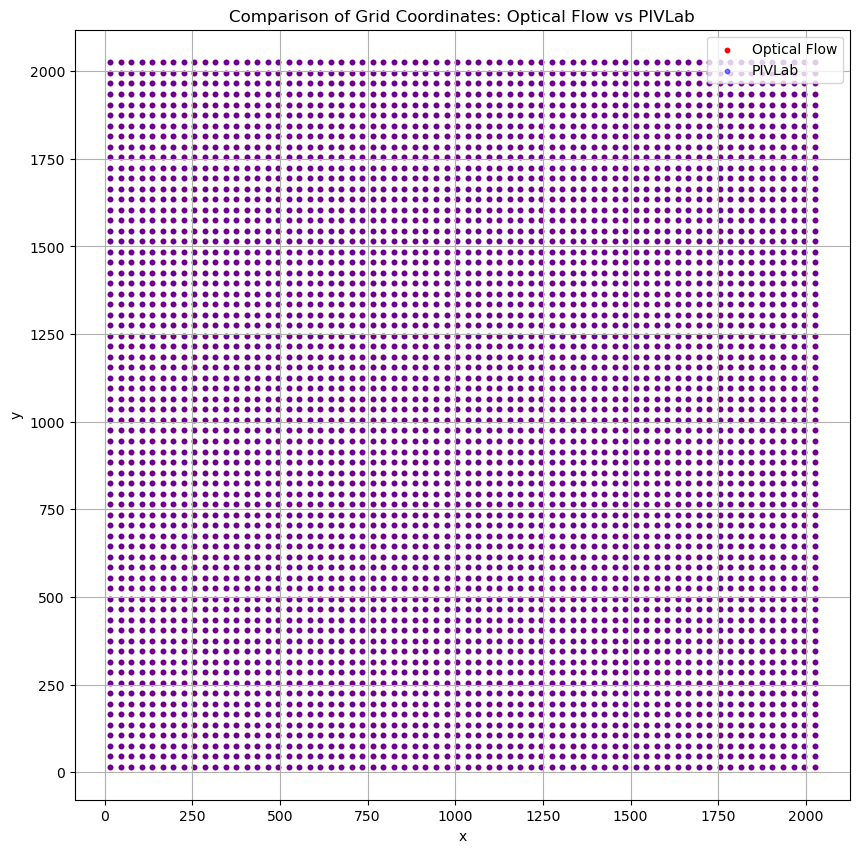

In [42]:
# Load Optical Flow Data from the pickle file
optical_flow_file = 'image_flow_results/velocity_data.pkl'  # Update this path to the actual path of your optical flow pkl file
with open(optical_flow_file, 'rb') as f:
    optical_flow_data = pickle.load(f)

# Extract the x and y coordinates from the optical flow data
# We assume that the x and y coordinates are constant across frames and can be extracted from the grid definition
grid_size = 30  # Use the same grid size as in the perform_PIV function

# Extract x and y coordinates from one of the grids (assuming the grid is the same for all frames)
UX_sample, UY_sample = optical_flow_data[0]
xrange, yrange = UX_sample.shape[1], UX_sample.shape[0]
x_grid = np.arange(grid_size / 2, xrange * grid_size, grid_size)
y_grid = np.arange(grid_size / 2, yrange * grid_size, grid_size)
X1, Y1 = np.meshgrid(x_grid, y_grid)

# Load PIVLab Data from the pickle file
pivlab_file = 'pivlab_results/pivlab_velocity_data.pkl'  # Update this path to the actual path of your PIVLab pickle file
with open(pivlab_file, 'rb') as f:
    pivlab_data = pickle.load(f)

# Extract the x and y coordinates from the PIVLab data
# Since the PIVLab data is averaged over a grid, we'll take the grid points from one of the entries
U_piv_sample, V_piv_sample = pivlab_data[0]
x_piv_range, y_piv_range = U_piv_sample.shape[1], U_piv_sample.shape[0]
x_piv_grid = np.arange(grid_size / 2, x_piv_range * grid_size, grid_size)
y_piv_grid = np.arange(grid_size / 2, y_piv_range * grid_size, grid_size)
X_piv, Y_piv = np.meshgrid(x_piv_grid, y_piv_grid)

# Plot the x and y coordinates
plt.figure(figsize=(10, 10))

# Plot Optical Flow grid coordinates
plt.scatter(X1.ravel(), Y1.ravel(), color='red', label='Optical Flow', s=10)

# Plot PIVLab coordinates
plt.scatter(X_piv.ravel(), Y_piv.ravel(), color='blue', label='PIVLab', s=10, alpha=0.5)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Comparison of Grid Coordinates: Optical Flow vs PIVLab')
plt.legend()
plt.grid(True)
plt.axis('equal')  # Ensures the aspect ratio is equal
plt.show()


Comparing frame 20 - PIVLab vs Ground Truth
RMSE for u-component: 2.3081
RMSE for v-component: 2.2166
Correlation coefficient for u-component: 0.4083
Correlation coefficient for v-component: 0.3598

Comparing frame 20 - Optical Flow vs Ground Truth
RMSE for u-component: 4.6133
RMSE for v-component: 3.1433
Correlation coefficient for u-component: 0.5311
Correlation coefficient for v-component: 0.5419


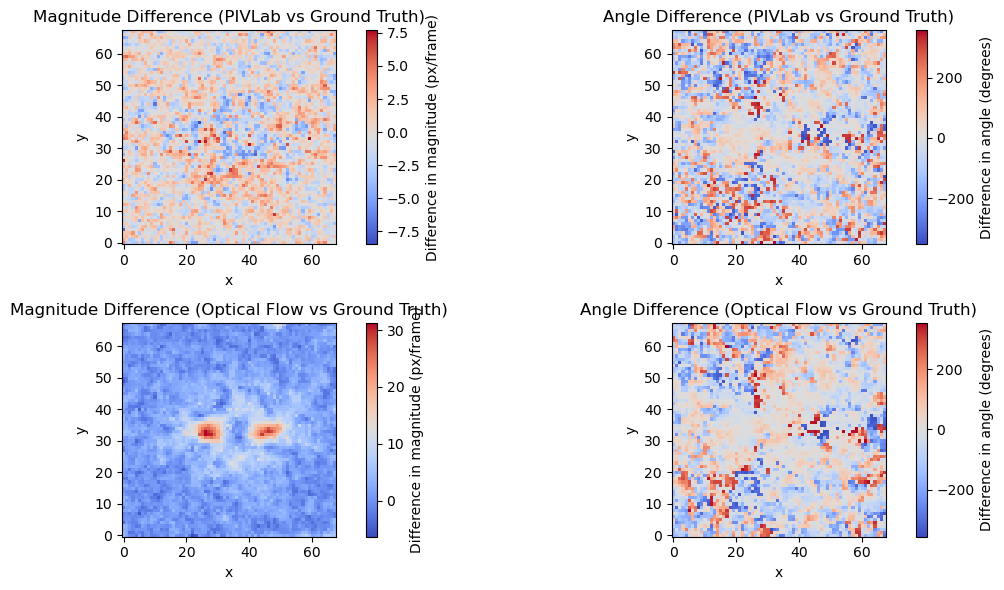

In [43]:
# Load Ground Truth Data
ground_truth_file = 'groundtruth/groundtruth.pkl'  # Update this path to the actual path of your ground truth pkl file
with open(ground_truth_file, 'rb') as f:
    ground_truth_data = pickle.load(f)

# Load PIVLab Data
pivlab_file = 'pivlab_results/pivlab_velocity_data.pkl'  # Update this path to the actual path of your PIVLab pkl file
with open(pivlab_file, 'rb') as f:
    pivlab_data = pickle.load(f)

# Load Optical Flow Data
optical_flow_file = 'image_flow_results/velocity_data.pkl'  # Update this path to the actual path of your optical flow pkl file
with open(optical_flow_file, 'rb') as f:
    optical_flow_data = pickle.load(f)

# Frame index to compare
frame_index = 20

# Extract data for the identified frame
UX_optical, VY_optical = optical_flow_data[frame_index]
U_piv, V_piv = pivlab_data[frame_index]
U_gt, V_gt = ground_truth_data[frame_index]

# Create grid for ground truth (assuming it is the reference grid)
grid_size = 30
x_range, y_range = U_gt.shape[1], U_gt.shape[0]
x_grid = np.arange(grid_size / 2, x_range * grid_size, grid_size)
y_grid = np.arange(grid_size / 2, y_range * grid_size, grid_size)
X_gt, Y_gt = np.meshgrid(x_grid, y_grid)

# Interpolate PIVLab and Optical Flow data to match the Ground Truth grid
U_piv_interp = griddata((X_gt.ravel(), Y_gt.ravel()), U_piv.ravel(), (X_gt, Y_gt), method='linear')
V_piv_interp = griddata((X_gt.ravel(), Y_gt.ravel()), V_piv.ravel(), (X_gt, Y_gt), method='linear')
U_optical_interp = griddata((X_gt.ravel(), Y_gt.ravel()), UX_optical.ravel(), (X_gt, Y_gt), method='linear')
V_optical_interp = griddata((X_gt.ravel(), Y_gt.ravel()), VY_optical.ravel(), (X_gt, Y_gt), method='linear')

# Compute metrics for PIVLab vs Ground Truth
def compute_metrics(U_pred, V_pred, U_gt, V_gt):
    magnitude_pred = np.sqrt(U_pred**2 + V_pred**2)
    magnitude_gt = np.sqrt(U_gt**2 + V_gt**2)
    magnitude_difference = magnitude_pred - magnitude_gt
    
    angle_pred = np.arctan2(V_pred, U_pred)
    angle_gt = np.arctan2(V_gt, U_gt)
    angle_difference = np.rad2deg(angle_pred - angle_gt)
    
    rmse_u = np.sqrt(mean_squared_error(U_gt, U_pred))
    rmse_v = np.sqrt(mean_squared_error(V_gt, V_pred))
    
    correlation_u = np.corrcoef(U_gt.ravel(), U_pred.ravel())[0, 1]
    correlation_v = np.corrcoef(V_gt.ravel(), V_pred.ravel())[0, 1]
    
    return {
        'magnitude_difference': magnitude_difference,
        'angle_difference': angle_difference,
        'rmse_u': rmse_u,
        'rmse_v': rmse_v,
        'correlation_u': correlation_u,
        'correlation_v': correlation_v
    }

metrics_piv = compute_metrics(U_piv_interp, V_piv_interp, U_gt, V_gt)
metrics_optical = compute_metrics(U_optical_interp, V_optical_interp, U_gt, V_gt)

# Display metrics
print(f"Comparing frame {frame_index} - PIVLab vs Ground Truth")
print(f"RMSE for u-component: {metrics_piv['rmse_u']:.4f}")
print(f"RMSE for v-component: {metrics_piv['rmse_v']:.4f}")
print(f"Correlation coefficient for u-component: {metrics_piv['correlation_u']:.4f}")
print(f"Correlation coefficient for v-component: {metrics_piv['correlation_v']:.4f}")

print(f"\nComparing frame {frame_index} - Optical Flow vs Ground Truth")
print(f"RMSE for u-component: {metrics_optical['rmse_u']:.4f}")
print(f"RMSE for v-component: {metrics_optical['rmse_v']:.4f}")
print(f"Correlation coefficient for u-component: {metrics_optical['correlation_u']:.4f}")
print(f"Correlation coefficient for v-component: {metrics_optical['correlation_v']:.4f}")

# Plot magnitude difference for PIVLab vs Ground Truth
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.title('Magnitude Difference (PIVLab vs Ground Truth)')
plt.imshow(metrics_piv['magnitude_difference'], cmap='coolwarm', origin='lower')
plt.colorbar(label='Difference in magnitude (px/frame)')
plt.xlabel('x')
plt.ylabel('y')

# Plot angle difference for PIVLab vs Ground Truth
plt.subplot(2, 2, 2)
plt.title('Angle Difference (PIVLab vs Ground Truth)')
plt.imshow(metrics_piv['angle_difference'], cmap='coolwarm', origin='lower')
plt.colorbar(label='Difference in angle (degrees)')
plt.xlabel('x')
plt.ylabel('y')

# Plot magnitude difference for Optical Flow vs Ground Truth
plt.subplot(2, 2, 3)
plt.title('Magnitude Difference (Optical Flow vs Ground Truth)')
plt.imshow(metrics_optical['magnitude_difference'], cmap='coolwarm', origin='lower')
plt.colorbar(label='Difference in magnitude (px/frame)')
plt.xlabel('x')
plt.ylabel('y')

# Plot angle difference for Optical Flow vs Ground Truth
plt.subplot(2, 2, 4)
plt.title('Angle Difference (Optical Flow vs Ground Truth)')
plt.imshow(metrics_optical['angle_difference'], cmap='coolwarm', origin='lower')
plt.colorbar(label='Difference in angle (degrees)')
plt.xlabel('x')
plt.ylabel('y')

plt.tight_layout()
plt.show()


/opt/anaconda3/envs/active_matters/lib/python3.9/site-packages/numpy/lib/function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/opt/anaconda3/envs/active_matters/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/envs/active_matters/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


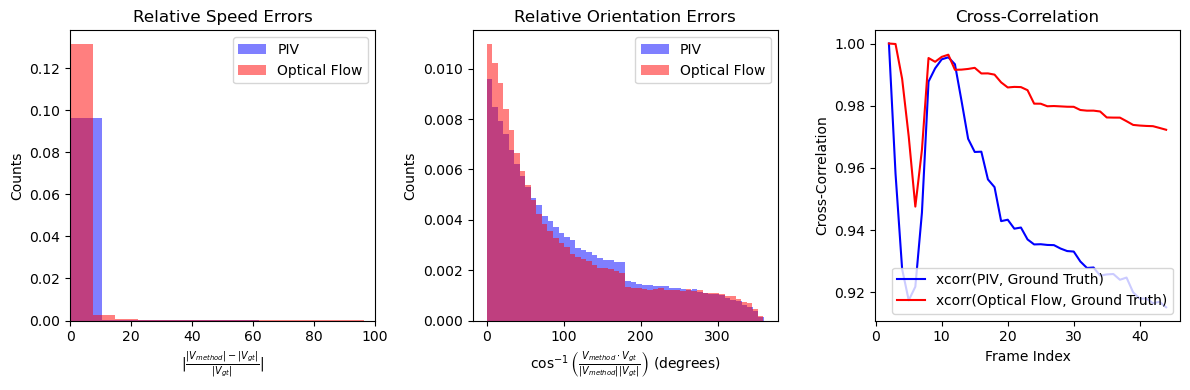

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from sklearn.metrics import mean_squared_error
import pickle

# Load Ground Truth Data
ground_truth_file = 'groundtruth/groundtruth.pkl'  # Update this path to the actual path of your ground truth pkl file
with open(ground_truth_file, 'rb') as f:
    ground_truth_data = pickle.load(f)

# Load PIVLab Data
pivlab_file = 'pivlab_results/pivlab_velocity_data.pkl'  # Update this path to the actual path of your PIVLab pkl file
with open(pivlab_file, 'rb') as f:
    pivlab_data = pickle.load(f)

# Load Optical Flow Data
optical_flow_file = 'image_flow_results/velocity_data.pkl'  # Update this path to the actual path of your optical flow pkl file
with open(optical_flow_file, 'rb') as f:
    optical_flow_data = pickle.load(f)

# Frame indices to compare
frame_indices = range(1, 45)

# Initialize lists to store the computed errors
relative_speed_errors_piv = []
relative_speed_errors_optical = []
relative_orientation_errors_piv = []
relative_orientation_errors_optical = []
mean_speed_ground_truth = []
mean_speed_piv = []
mean_speed_optical = []
cross_corr_piv = []
cross_corr_optical = []

# Helper function to compute errors and mean speed
def compute_errors_and_mean_speed(U_pred, V_pred, U_gt, V_gt):
    magnitude_pred = np.sqrt(U_pred**2 + V_pred**2)
    magnitude_gt = np.sqrt(U_gt**2 + V_gt**2)
    
    # Avoid division by zero by setting a small threshold
    with np.errstate(divide='ignore', invalid='ignore'):
        relative_speed_error = np.abs(magnitude_pred - magnitude_gt) / np.where(magnitude_gt > 1e-10, magnitude_gt, np.nan)
    
    angle_pred = np.arctan2(V_pred, U_pred)
    angle_gt = np.arctan2(V_gt, U_gt)
    relative_orientation_error = np.abs(np.rad2deg(angle_pred - angle_gt))
    
    mean_speed_pred = magnitude_pred.mean()
    mean_speed_gt = magnitude_gt.mean()
    
    return relative_speed_error, relative_orientation_error, mean_speed_pred, mean_speed_gt

# Compute errors and mean speeds for each frame
for frame_index in frame_indices:
    U_gt, V_gt = ground_truth_data[frame_index]
    U_piv, V_piv = pivlab_data[frame_index]
    UX_optical, VY_optical = optical_flow_data[frame_index]

    # Interpolate PIVLab and Optical Flow data to match the Ground Truth grid
    grid_size = 30
    x_range, y_range = U_gt.shape[1], U_gt.shape[0]
    x_grid = np.arange(grid_size / 2, x_range * grid_size, grid_size)
    y_grid = np.arange(grid_size / 2, y_range * grid_size, grid_size)
    X_gt, Y_gt = np.meshgrid(x_grid, y_grid)
    
    U_piv_interp = griddata((X_gt.ravel(), Y_gt.ravel()), U_piv.ravel(), (X_gt, Y_gt), method='linear')
    V_piv_interp = griddata((X_gt.ravel(), Y_gt.ravel()), V_piv.ravel(), (X_gt, Y_gt), method='linear')
    U_optical_interp = griddata((X_gt.ravel(), Y_gt.ravel()), UX_optical.ravel(), (X_gt, Y_gt), method='linear')
    V_optical_interp = griddata((X_gt.ravel(), Y_gt.ravel()), VY_optical.ravel(), (X_gt, Y_gt), method='linear')
    
    # Compute errors and mean speeds for PIVLab data
    rel_speed_error_piv, rel_orient_error_piv, mean_speed_piv_frame, mean_speed_gt_frame = compute_errors_and_mean_speed(U_piv_interp, V_piv_interp, U_gt, V_gt)
    relative_speed_errors_piv.extend(np.nan_to_num(rel_speed_error_piv.flatten(), nan=0.0, posinf=1.0, neginf=1.0))  # Replace NaNs and infs for plotting
    relative_orientation_errors_piv.extend(np.nan_to_num(rel_orient_error_piv.flatten(), nan=0.0, posinf=180.0, neginf=180.0))  # Replace NaNs and infs for plotting
    mean_speed_piv.append(mean_speed_piv_frame)
    
    # Compute errors and mean speeds for Optical Flow data
    rel_speed_error_optical, rel_orient_error_optical, mean_speed_optical_frame, _ = compute_errors_and_mean_speed(U_optical_interp, V_optical_interp, U_gt, V_gt)
    relative_speed_errors_optical.extend(np.nan_to_num(rel_speed_error_optical.flatten(), nan=0.0, posinf=1.0, neginf=1.0))  # Replace NaNs and infs for plotting
    relative_orientation_errors_optical.extend(np.nan_to_num(rel_orient_error_optical.flatten(), nan=0.0, posinf=180.0, neginf=180.0))  # Replace NaNs and infs for plotting
    mean_speed_optical.append(mean_speed_optical_frame)
    
    # Ground truth mean speed is consistent across comparisons
    mean_speed_ground_truth.append(mean_speed_gt_frame)

# Convert lists to numpy arrays for further processing
mean_speed_ground_truth = np.array(mean_speed_ground_truth)
mean_speed_piv = np.array(mean_speed_piv)
mean_speed_optical = np.array(mean_speed_optical)

# Compute cross-correlation
for frame_index in frame_indices:
    corr_piv = np.corrcoef(mean_speed_ground_truth[:frame_index], mean_speed_piv[:frame_index])[0, 1]
    corr_optical = np.corrcoef(mean_speed_ground_truth[:frame_index], mean_speed_optical[:frame_index])[0, 1]
    cross_corr_piv.append(corr_piv)
    cross_corr_optical.append(corr_optical)

# Plot relative speed errors
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(relative_speed_errors_piv, bins=50, alpha=0.5, color='blue', label='PIV', density=True)
plt.hist(relative_speed_errors_optical, bins=50, alpha=0.5, color='red', label='Optical Flow', density=True)
plt.xlabel(r'$|\frac{|V_{method}| - |V_{gt}|}{|V_{gt}|}|$')
plt.ylabel('Counts')
plt.title('Relative Speed Errors')
plt.legend()
plt.xlim(0, 100)

# Plot relative orientation errors
plt.subplot(1, 3, 2)
plt.hist(relative_orientation_errors_piv, bins=50, alpha=0.5, color='blue', label='PIV', density=True)
plt.hist(relative_orientation_errors_optical, bins=50, alpha=0.5, color='red', label='Optical Flow', density=True)
plt.xlabel(r'$\cos^{-1}\left(\frac{V_{method} \cdot V_{gt}}{|V_{method}||V_{gt}|}\right)$ (degrees)')
plt.ylabel('Counts')
plt.title('Relative Orientation Errors')
plt.legend()


# Plot cross-correlation
plt.subplot(1, 3, 3)
plt.plot(frame_indices, cross_corr_piv, label='xcorr(PIV, Ground Truth)', color='blue')
plt.plot(frame_indices, cross_corr_optical, label='xcorr(Optical Flow, Ground Truth)', color='red')
plt.xlabel('Frame Index')
plt.ylabel('Cross-Correlation')
plt.title('Cross-Correlation')
plt.legend()
plt.legend(loc='lower right')


plt.tight_layout()
plt.show()
